In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import r2_score

In [2]:
np.random.seed(3888)
tf.random.set_seed(3888)

In [3]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [4]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create liquidity, micro‑structure and realised‑volatility features."""
    # --- Level‑1 mid‑price & spread
    df["mid_price"] = (df["bid_price1"] + df["ask_price1"]) / 2
    df["spread"]    = df["ask_price1"] - df["bid_price1"]

    # --- Imbalance, book pressure and micro‑price
    with np.errstate(divide="ignore", invalid="ignore"):
        num  = df["bid_size1"] - df["ask_size1"]
        den  = df["bid_size1"] + df["ask_size1"]
        df["imbalance"] = np.where(den > 0, num / den, 0.0)

        num2 = (df["bid_size1"] + df["bid_size2"]) - (df["ask_size1"] + df["ask_size2"])
        den2 = df[["bid_size1", "bid_size2", "ask_size1", "ask_size2"]].sum(axis=1)
        df["book_pressure"] = np.where(den2 > 0, num2 / den2, 0.0)

        num3 = (df["ask_price1"] * df["bid_size1"] +
                df["bid_price1"] * df["ask_size1"])
        df["microprice"] = np.where(den > 0, num3 / den, df["mid_price"])

    # --- Normalised spread & level‑2 imbalance
    df["normalized_spread"] = df["spread"] / df["mid_price"].replace(0, np.nan)
    df["OBI_L2"] = np.where(
        den2 > 0,
        (df["bid_size1"] + df["bid_size2"]) / den2,
        0.5                                   # neutral book ‑ avoids NaNs
    )

    # --- Liquidity‑distribution entropy
    sizes  = df[["bid_size1","bid_size2","ask_size1","ask_size2"]].astype(float).values
    total  = sizes.sum(axis=1, keepdims=True)
    p      = np.divide(sizes, total, where=total != 0)
    ent    = -np.nansum(np.where(p > 0, p * np.log(p), 0.0), axis=1)
    df["LOB_entropy"]            = ent
    df["LOB_entropy_normalized"] = ent / np.log(4)

    # --- Log‑returns & 30‑tick realised‑volatility/bipower‑variance
    df["log_return"] = (
        df.groupby("time_id")["mid_price"]
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    df["realized_volatility"] = (
        df.groupby("time_id")["log_return"]
          .transform(
              lambda x: np.sqrt(
                  (x.shift(1)**2).rolling(window=30, min_periods=30).sum()
              )
          )
    )

    df["bipower_var"] = (
        df.groupby("time_id")["log_return"]
          .transform(
              lambda x: (
                  x.abs().shift(1)
                    .rolling(2, min_periods=2)
                    .apply(lambda r: r[0] * r[1], raw=True)
                    .rolling(30, min_periods=30)
                    .mean()
              )
          )
    )

    # --- Finishing touches
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    return df

In [5]:
df = make_features(df)

In [6]:
feature_cols = [
    "mid_price", "spread", "imbalance", "book_pressure", "microprice",
    "normalized_spread", "OBI_L2", "LOB_entropy", "LOB_entropy_normalized"
] # "bipower_var"
target_col = "realized_volatility"

In [7]:
unique_sessions = df["time_id"].sort_values().unique()
split_idx       = int(len(unique_sessions) * 0.8)          
train_sessions  = unique_sessions[:split_idx]
test_sessions   = unique_sessions[split_idx:]

In [8]:
train_df = df[df["time_id"].isin(train_sessions)].reset_index(drop=True)
test_df  = df[df["time_id"].isin(test_sessions)].reset_index(drop=True)

In [9]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler(feature_range=(0, 1))

x_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[target_col]])

train_df[feature_cols] = x_scaler.transform(train_df[feature_cols])
test_df[feature_cols]  = x_scaler.transform(test_df[feature_cols])

train_df[target_col] = y_scaler.transform(train_df[[target_col]])
test_df[target_col]  = y_scaler.transform(test_df[[target_col]])

In [10]:
SEQ_LEN = 30   

def build_sequences(df_part: pd.DataFrame, feature_cols, target_col, seq_len):
    """Return X, y arrays where each sample is wholly inside one session."""
    X, y = [], []
    for _, session in df_part.groupby("time_id"):
        data   = session[feature_cols].values
        target = session[target_col].values
        for i in range(len(session) - seq_len):
            X.append(data[i : i + seq_len])
            y.append(target[i + seq_len])
    return np.asarray(X), np.asarray(y)

X_train, y_train = build_sequences(train_df, feature_cols, target_col, SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols, target_col, SEQ_LEN)


In [11]:
def build_transformer_model(seq_len, num_features,
                            d_model=64, num_heads=4, num_layers=2):
    inputs = layers.Input(shape=(seq_len, num_features))

    # Linear projection to d_model
    x = layers.Dense(d_model)(inputs)

    # Stacked Transformer encoder blocks
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        ffn_out = layers.Dense(d_model * 4, activation="relu")(x)
        ffn_out = layers.Dense(d_model)(ffn_out)
        x       = layers.Add()([x, ffn_out])
        x       = layers.LayerNormalization(epsilon=1e-6)(x)

    x      = layers.GlobalAveragePooling1D()(x)   # time pooling
    output = layers.Dense(1)(x)
    return models.Model(inputs, output)

model = build_transformer_model(SEQ_LEN, len(feature_cols))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

In [12]:
val_split_idx = int(len(train_sessions) * 0.9)
val_mask      = train_df["time_id"].isin(train_sessions[val_split_idx:])

X_val, y_val  = build_sequences(train_df[val_mask], feature_cols, target_col, SEQ_LEN)

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

history = model.fit(X_train, y_train, validation_split=0.01, epochs=2, batch_size=32, callbacks=[early_stop], verbose=1,)

Epoch 1/2
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 333s 20ms/step - loss: 0.0131 - val_loss: 6.8791e-04
Epoch 2/2
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 306s 18ms/step - loss: 8.7135e-04 - val_loss: 5.5008e-04


In [13]:
pred_scaled = model.predict(X_test, verbose=1).flatten()
actual_scaled = y_test.flatten()

predictions = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actuals     = y_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).flatten()

mse   = np.mean((predictions - actuals) ** 2)
rmse  = np.sqrt(mse)
print(f"Test RMSE (volatility): {rmse:.9f}")

4192/4192 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step
Test RMSE (volatility): 0.000400213


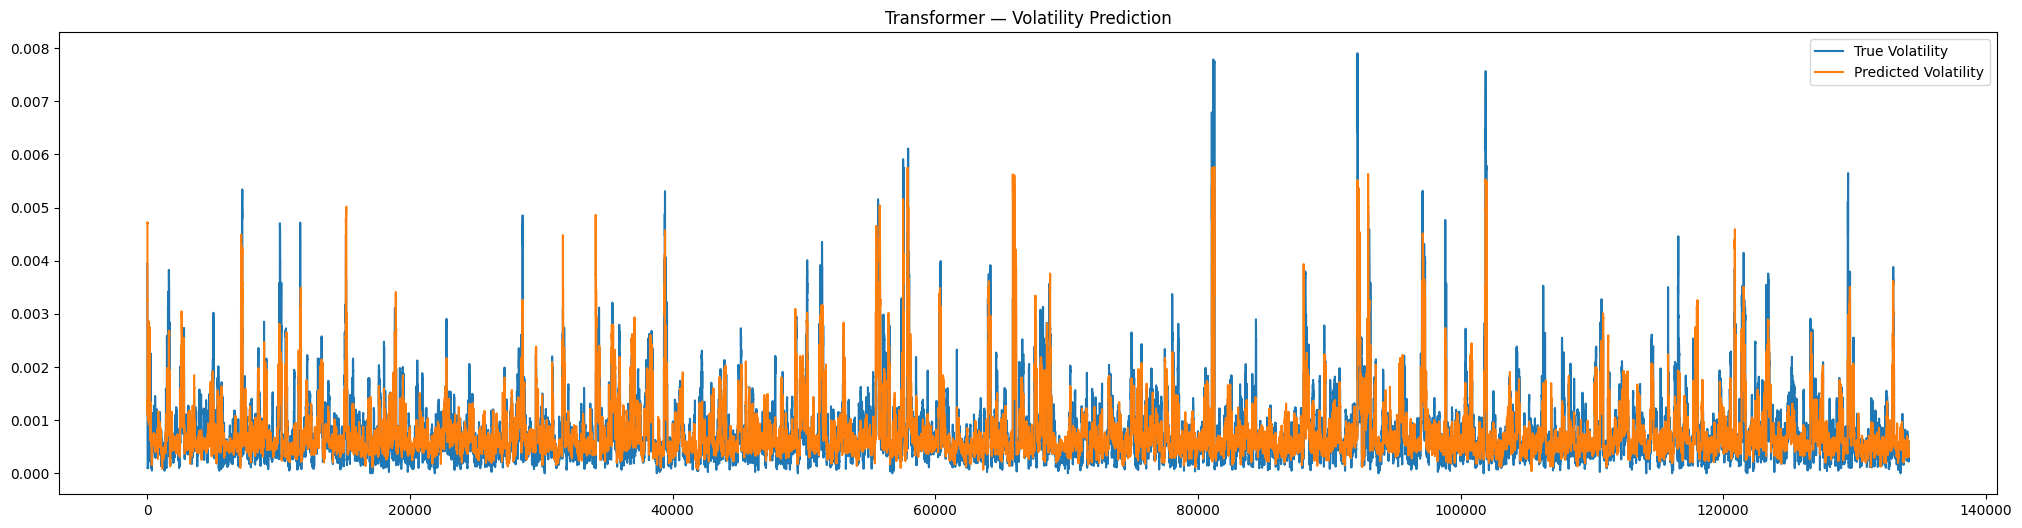

In [14]:
plt.figure(figsize=(25, 6))
plt.plot(actuals, label="True Volatility")
plt.plot(predictions, label="Predicted Volatility")
plt.legend()
plt.title("Transformer — Volatility Prediction")
plt.show()

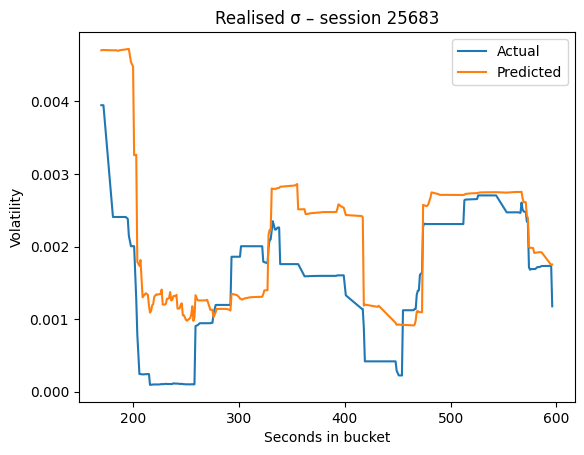

In [15]:
first_session = test_sessions[0]
mask          = test_df["time_id"] == first_session
session_steps = test_df.loc[mask, "seconds_in_bucket"].values[SEQ_LEN:]

plt.figure()
plt.plot(session_steps, actuals[: len(session_steps)], label="Actual")
plt.plot(session_steps, predictions[: len(session_steps)], label="Predicted")
plt.title(f"Realised σ – session {first_session}")
plt.xlabel("Seconds in bucket")
plt.ylabel("Volatility")
plt.legend()
plt.show()

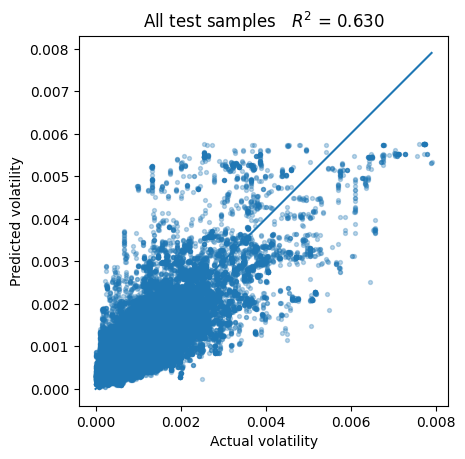

In [16]:
plt.figure()
plt.scatter(actuals, predictions, alpha=0.3, s=8)
lim = [min(actuals.min(), predictions.min()),
       max(actuals.max(), predictions.max())]
plt.plot(lim, lim)                     # ideal fit
plt.title(f"All test samples   $R^2$ = {r2_score(actuals, predictions):.3f}")
plt.xlabel("Actual volatility")
plt.ylabel("Predicted volatility")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

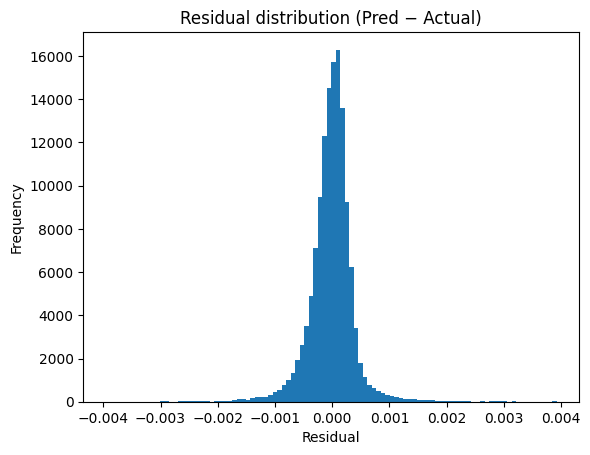

In [17]:
residuals = predictions - actuals
plt.figure()
plt.hist(residuals, bins=100)
plt.title("Residual distribution (Pred − Actual)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

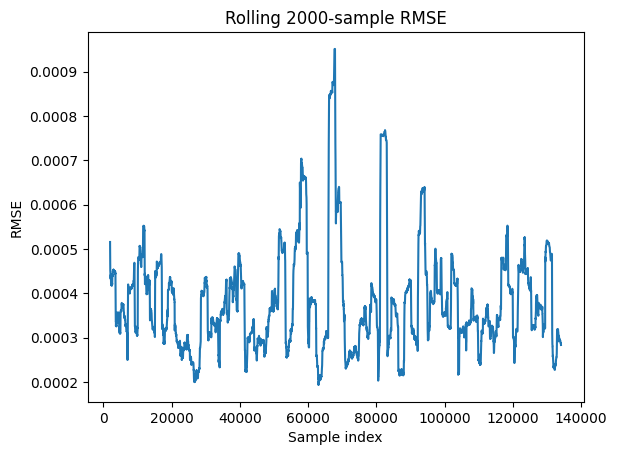

In [18]:
WINDOW = 2_000                     
rmse_roll = np.sqrt(
    pd.Series(residuals**2).rolling(WINDOW).mean()
)

plt.figure()
plt.plot(rmse_roll)
plt.title(f"Rolling {WINDOW}-sample RMSE")
plt.xlabel("Sample index")
plt.ylabel("RMSE")
plt.show()